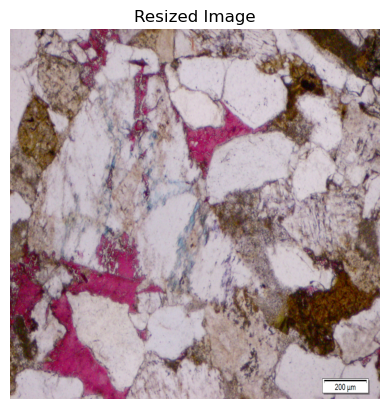

Number of masks generated: 236


In [1]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def filter_masks(masks, threshold):
    filter_masks = []
    total = masks[0]['segmentation'].shape[0] * masks[0]['segmentation'].shape[1]
    for i, mask_data in enumerate(masks):
        mask = mask_data["segmentation"]
        # filter
        total_value = np.sum(mask)
        percentage = total_value / total
        if percentage > threshold:
            continue
        filter_masks.append(mask_data)
    return filter_masks

## visual
def save_anns(image, anns, save_path):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    plt.axis('off')
    plt.savefig(save_path)
    plt.close()

def write_masks_to_folder(image, masks, path, image_suffix, threshold=None):
    header = "id,area,bbox_x0,bbox_y0,bbox_w,bbox_h,point_input_x,point_input_y,predicted_iou,stability_score,crop_box_x0,crop_box_y0,crop_box_w,crop_box_h"  # noqa
    metadata = [header]
    # filter masks
    if threshold is not None:
        masks = filter_masks(masks, threshold)
    # save visual annotation fig
    save_anns(image, masks, os.path.join(path, 'full_mask'+image_suffix))
    # save each mask
    for i, mask_data in enumerate(masks):
        mask = mask_data["segmentation"]
        filename = f"{i}"+image_suffix
        cv2.imwrite(os.path.join(path, filename), mask * 255)
        mask_metadata = [
            str(i),
            str(mask_data["area"]),
            *[str(x) for x in mask_data["bbox"]],
            *[str(x) for x in mask_data["point_coords"][0]],
            str(mask_data["predicted_iou"]),
            str(mask_data["stability_score"]),
            *[str(x) for x in mask_data["crop_box"]],
        ]
        row = ",".join(mask_metadata)
        metadata.append(row)
    metadata_path = os.path.join(path, "metadata.csv")
    with open(metadata_path, "w") as f:
        f.write("\n".join(metadata))
    return

sam_checkpoint = '/home/a6/vis/LDS/SAM/weights/sam_vit_h_4b8939.pth'
model_type = 'vit_h'
device = 'cuda'
image_path = '/home/a6/vis/LDS/SAM/images/S1-B12m2-.png'

# create sam
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_model.to(device=device)
# sam_model.eval()
mask_generator = SamAutomaticMaskGenerator(
    model=sam_model,
    points_per_side=64,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.75,
    crop_n_layers=2,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

# load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image=cv2.resize(image,(1024,1024))

# 使用 matplotlib 展示图像
plt.imshow(image)
plt.title('Resized Image')
plt.axis('off')  # 隐藏坐标轴
plt.show()

masks = mask_generator.generate(image)
print(f'Number of masks generated: {len(masks)}')

# specify the directory to save masks
masks_dir = '/home/a6/vis/LDS/SAM/masks'
os.makedirs(masks_dir, exist_ok=True)

# save masks to the specified directory
write_masks_to_folder(image, masks, masks_dir, '.png', threshold=0.3)

In [2]:
import json
import logging
import torch.nn.functional as F
import torch

# 创建 logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

output_dir = '/home/a6/vis/LDS/SAM/outputs'
mask_vec_npy_dir = os.path.join(output_dir, 'npy_masks')
json_mask_avg_vec_save_path = os.path.join(output_dir, 'json_masks')
# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(mask_vec_npy_dir, exist_ok=True)
os.makedirs(json_mask_avg_vec_save_path, exist_ok=True)

image_torch = torch.as_tensor(image, device=device)
transformed_image = image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
input_image = sam_model.preprocess(transformed_image)
with torch.no_grad():
    image_embedding = sam_model.image_encoder(input_image)  # [B, C, H, W]
b, c, h, w = image_embedding.shape

# Process each mask
masked_feature_list = {}
mask_files = [f for f in os.listdir(masks_dir) if f.endswith('.png')]
mask_vecs = []
for mask_file in mask_files:
    mask_path = os.path.join(masks_dir, mask_file)
    mask_name = os.path.splitext(mask_file)[0]
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = mask.astype(np.float32) / 255.0  # Normalize mask to [0, 1]
    mask = torch.as_tensor(mask, device=device)[None, None, :, :]  # [1, 1, H, W]
    
    # Rescale features and mask
    rescale_factor = 4  # 4x upsample/downsample
    t1, t2 = int(mask.shape[2] / rescale_factor), int(mask.shape[3] / rescale_factor)
    features_rescale = F.interpolate(image_embedding, size=[t1, t2], mode='bilinear')
    mask_rescale = F.interpolate(mask, size=[t1, t2], mode='bilinear')

    masked_feature = torch.mul(features_rescale, mask_rescale)
    masked_feature = masked_feature.view(b, c, -1)
    non_zero_count = torch.count_nonzero(masked_feature, dim=2)
    
    # Calculate average vector for mask
    masked_avg_vec = masked_feature.sum(dim=2) / non_zero_count
    masked_avg_vec[torch.isnan(masked_avg_vec)] = 0
    
    # Save masked feature vector
    npy_data = masked_avg_vec.detach().cpu().numpy()
    single_mask_vec_path = os.path.join(mask_vec_npy_dir, mask_name + '.npy')
    np.save(single_mask_vec_path, npy_data)
    masked_feature_list[mask_name] = single_mask_vec_path
    mask_vecs.append(npy_data)

# Save image and mask info to JSON
img_info = {
    'image_name': os.path.basename(image_path),
    'mask_avg_vec': masked_feature_list
}
json_save_name = os.path.join(json_mask_avg_vec_save_path, os.path.splitext(os.path.basename(image_path))[0] + '_mask_vec.json')
with open(json_save_name, "w") as file:
    json.dump(img_info, file)

logger.info(f'Saving image: {os.path.basename(image_path)} all masks as {json_save_name}.')



Top similar vectors with similarity > 0.75:
File: 40.npy, Similarity: 0.7853336334228516
File: 174.npy, Similarity: 1.0000001192092896
File: 74.npy, Similarity: 0.8431430459022522
File: 89.npy, Similarity: 0.6490788459777832
File: 161.npy, Similarity: 0.7323848605155945
File: 78.npy, Similarity: 0.7540453672409058
File: 165.npy, Similarity: 0.6015232801437378
File: 180.npy, Similarity: 0.7533073425292969
File: 155.npy, Similarity: 0.6785005927085876
File: 195.npy, Similarity: 0.7197515964508057
File: 55.npy, Similarity: 0.8098095655441284
File: 181.npy, Similarity: 0.7918757200241089
File: 189.npy, Similarity: 0.7945048213005066
File: 58.npy, Similarity: 0.8221700191497803
File: 67.npy, Similarity: 0.8176074028015137
File: 50.npy, Similarity: 0.8367494344711304
File: 12.npy, Similarity: 0.7396763563156128
File: 178.npy, Similarity: 0.8659158945083618
File: 36.npy, Similarity: 0.7304865121841431
File: 156.npy, Similarity: 0.7572023868560791
File: 151.npy, Similarity: 0.883093535900116
F

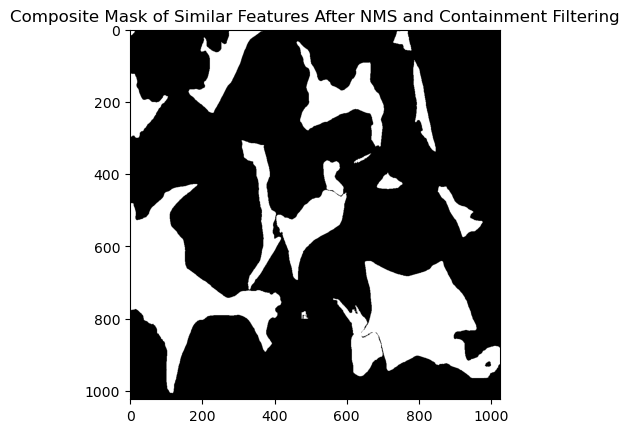

In [12]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision.ops import nms

# 加载所有 .npy 文件的特征向量
npy_dir = '/home/a6/vis/LDS/SAM/outputs/npy_masks'
npy_files = [f for f in os.listdir(npy_dir) if f.endswith('.npy')]
mask_dir = '/home/a6/vis/LDS/SAM/masks'

features = []
file_names = []

for npy_file in npy_files:
    file_path = os.path.join(npy_dir, npy_file)
    features.append(np.load(file_path))
    file_names.append(npy_file)

# 将特征向量转换为 NumPy 数组
features = np.array(features).squeeze()  # Assuming features are [N, D]

# 指定查询的文件名
query_file_name = "174.npy"  # 替换为你要查询的文件名
if query_file_name in file_names:
    query_index = file_names.index(query_file_name)
    query_feature = features[query_index]
else:
    raise ValueError(f"File {query_file_name} not found in the directory.")

# 计算相似性
similarities = cosine_similarity([query_feature], features)[0]

# 找到相似度大于0.75的特征向量
threshold = 0.6
similar_indices = np.where(similarities > threshold)[0]

# 输出相似度
print("Top similar vectors with similarity > 0.75:")
for idx in similar_indices:
    print(f"File: {file_names[idx]}, Similarity: {similarities[idx]}")

# 生成边界框并应用非极大抑制
bboxes = []
scores = []

for idx in similar_indices:
    mask_name = os.path.splitext(file_names[idx])[0] + '.png'
    mask_path = os.path.join(mask_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        continue
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    bboxes.append([x_min, y_min, x_max, y_max])
    scores.append(similarities[idx])

# 转换为张量
bboxes = torch.tensor(bboxes, dtype=torch.float32)
scores = torch.tensor(scores, dtype=torch.float32)

# 应用非极大抑制
nms_indices = nms(bboxes, scores, iou_threshold=0.5)

# 过滤包含在更大掩码中的小掩码
kept_indices = []
for i in range(len(nms_indices)):
    keep = True
    for j in range(len(nms_indices)):
        if i != j:
            box_i = bboxes[nms_indices[i]]
            box_j = bboxes[nms_indices[j]]
            if (box_i[0] >= box_j[0] and box_i[1] >= box_j[1] and
                box_i[2] <= box_j[2] and box_i[3] <= box_j[3]):
                keep = False
                break
    if keep:
        kept_indices.append(nms_indices[i])

# 打印最终保留下来的掩码信息
print("Kept masks after NMS and containment filtering:")
for idx in kept_indices:
    mask_name = os.path.splitext(file_names[similar_indices[idx]])[0] + '.png'
    print(f"File: {mask_name}")

# 绘制复合掩码图像
image_shape = (1024, 1024)  # Assuming all masks are of this shape
composite_image = np.zeros(image_shape, dtype=np.float32)

for idx in kept_indices:
    mask_name = os.path.splitext(file_names[similar_indices[idx]])[0] + '.png'
    mask_path = os.path.join(mask_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
    composite_image = np.maximum(composite_image, mask)

# 绘制复合掩码图像
plt.imshow(composite_image, cmap='gray')
plt.title('Composite Mask of Similar Features After NMS and Containment Filtering')
plt.show()


[ 94 111 115 128]
Lowest similarity indices: [ 89  15  34 228 125]
Cluster 0: 125 masks
Kept masks in Cluster 0 after NMS and containment filtering:
File: 31.png
File: 225.png
File: 100.png
File: 174.png
File: 97.png
File: 74.png
File: 42.png
File: 89.png
File: 182.png
File: 78.png
File: 82.png
File: 157.png
File: 165.png
File: 159.png
File: 232.png
File: 180.png
File: 201.png
File: 218.png
File: 73.png
File: 101.png
File: 142.png
File: 152.png
File: 186.png
File: 20.png
File: 1.png
File: 63.png
File: 32.png
File: 95.png
File: 189.png
File: 205.png
File: 133.png
File: 85.png
File: 122.png
File: 91.png
File: 227.png
File: 23.png
File: 107.png
File: 12.png
File: 217.png
File: 145.png
File: 92.png
File: 187.png
File: 209.png
File: 202.png
File: 9.png
File: 69.png
File: 172.png
File: 3.png
File: 0.png
File: 160.png
File: 81.png
File: 129.png
File: 96.png
File: 62.png
File: 146.png
File: 68.png
File: 84.png
File: 5.png
File: 198.png
File: 199.png
File: 169.png
File: 13.png
File: 24.png
File

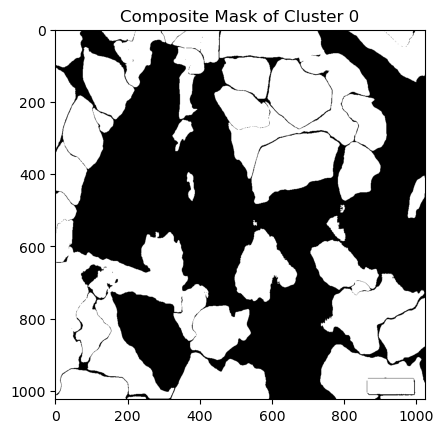

Cluster 1: 111 masks
Kept masks in Cluster 1 after NMS and containment filtering:
File: 123.png
File: 118.png
File: 40.png
File: 235.png
File: 131.png
File: 75.png
File: 126.png
File: 161.png
File: 44.png
File: 140.png
File: 212.png
File: 7.png
File: 25.png
File: 147.png
File: 6.png
File: 52.png
File: 190.png
File: 197.png
File: 155.png
File: 137.png
File: 173.png
File: 48.png
File: 230.png
File: 94.png
File: 55.png
File: 215.png
File: 108.png
File: 181.png
File: 222.png
File: 8.png
File: 127.png
File: 109.png
File: 125.png
File: 93.png
File: 138.png
File: 35.png
File: 110.png
File: 223.png
File: 28.png
File: 72.png
File: 58.png
File: 67.png
File: 46.png
File: 150.png
File: 139.png
File: 51.png
File: 214.png
File: 113.png
File: 144.png
File: 50.png
File: 53.png
File: 210.png
File: 178.png
File: 196.png
File: 79.png
File: 36.png
File: 2.png
File: 153.png
File: 151.png
File: 171.png
File: 41.png
File: 177.png
File: 194.png
File: 37.png
File: 49.png
File: 168.png
File: 116.png
File: 26.pn

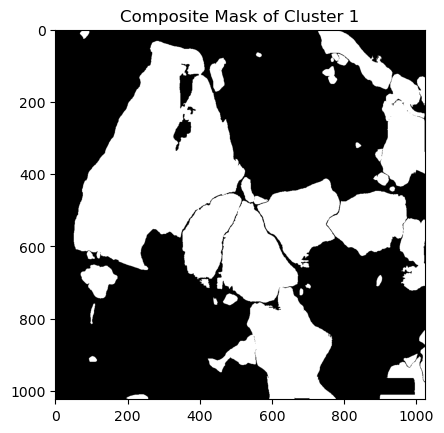

In [10]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision.ops import nms

# 加载所有 .npy 文件的特征向量
npy_dir = '/home/a6/vis/LDS/SAM/outputs/npy_masks'
npy_files = [f for f in os.listdir(npy_dir) if f.endswith('.npy')]
mask_dir = '/home/a6/vis/LDS/SAM/masks'

features = []
file_names = []

for npy_file in npy_files:
    file_path = os.path.join(npy_dir, npy_file)
    features.append(np.load(file_path))
    file_names.append(npy_file)

# 将特征向量转换为 NumPy 数组
features = np.array(features).squeeze()  # Assuming features are [N, D]

# 指定查询的文件名
query_file_name = "209.npy"  # 替换为你要查询的文件名
if query_file_name in file_names:
    query_index = file_names.index(query_file_name)
    query_feature = features[query_index]
else:
    raise ValueError(f"File {query_file_name} not found in the directory.")

# 计算相似性
similarities = cosine_similarity([query_feature], features)[0]

# 设定查询阈值
threshold_A = 0.85

# 找到相似度大于阈值A的特征向量
indices_A = np.where(similarities > threshold_A)[0]
print(indices_A)

# 找到相似度最低的十个特征向量
lowest_indices = np.argsort(similarities)[:5]
print('Lowest similarity indices:', lowest_indices)

# 合并特征
feature_A = np.mean(features[indices_A], axis=0)
feature_B = np.mean(features[lowest_indices], axis=0)

# 使用KMeans进行二分类，指定初始聚类中心
initial_centers = np.array([feature_A, feature_B])
kmeans = KMeans(n_clusters=2, init=initial_centers, n_init=1, random_state=0)
labels = kmeans.fit_predict(features)

# 为每个类别生成掩码图像并应用NMS和掩码过滤
for cluster_id in range(2):
    cluster_indices = np.where(labels == cluster_id)[0]
    print(f"Cluster {cluster_id}: {len(cluster_indices)} masks")

    # 生成边界框
    bboxes = []
    scores = []

    for idx in cluster_indices:
        mask_name = os.path.splitext(file_names[idx])[0] + '.png'
        mask_path = os.path.join(mask_dir, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        y_indices, x_indices = np.where(mask > 0)
        if len(y_indices) == 0 or len(x_indices) == 0:
            continue
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        bboxes.append([x_min, y_min, x_max, y_max])
        scores.append(1.0)  # For NMS, we can use a constant score

    # 转换为张量
    bboxes = torch.tensor(bboxes, dtype=torch.float32)
    scores = torch.tensor(scores, dtype=torch.float32)

    # 应用非极大抑制
    nms_indices = nms(bboxes, scores, iou_threshold=0.3)

    # 打印最终保留下来的掩码信息
    print(f"Kept masks in Cluster {cluster_id} after NMS and containment filtering:")
    for idx in nms_indices:
        mask_name = os.path.splitext(file_names[cluster_indices[idx]])[0] + '.png'
        print(f"File: {mask_name}")

    # 绘制复合掩码图像
    image_shape = (1024, 1024)  # Assuming all masks are of this shape
    composite_image = np.zeros(image_shape, dtype=np.float32)

    for idx in nms_indices:
        mask_name = os.path.splitext(file_names[cluster_indices[idx]])[0] + '.png'
        mask_path = os.path.join(mask_dir, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
        composite_image = np.maximum(composite_image, mask)

    # 绘制复合掩码图像
    plt.imshow(composite_image, cmap='gray')
    plt.title(f'Composite Mask of Cluster {cluster_id}')
    plt.show()
